In [1]:
import sys
sys.path.append("../src") # Adds higher directory to python modules path.

from early_text_classifier import EarlyTextClassifier
import numpy as np
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score,\
    confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
etc_kwargs = {'dataset_path': '../dataset/erisk',
              'dataset_name': 'erisk-clean-stemmed',
              'initial_step': 1,
              'step_size': 1}
preprocess_kwargs = {'min_word_length': 2,
                     'max_number_words': 'all'}
cpi_kwargs = {'train_dataset_percentage': 0.75,
              'test_dataset_percentage': 0.25,
              'doc_rep': 'term_frec',
              'cpi_clf': None}
context_kwargs = {'number_most_common': 100}
dmc_kwargs = {'train_dataset_percentage': 0.75,
              'test_dataset_percentage': 0.25,
              'dmc_clf': None}

In [3]:
cpi_clf_names = ['DecisionTreeClassifier', 'MultinomialNB', 'KNeighborsClassifier',
                 'LinearSVC', 'LogisticRegression', 'MLPClassifier', 'RandomForestClassifier',
                 'RidgeClassifier']
dmc_clf_names = ['DecisionTreeClassifier', 'MultinomialNB', 'KNeighborsClassifier',
                 'LinearSVC', 'LogisticRegression', 'MLPClassifier', 'RandomForestClassifier',
                 'RidgeClassifier']

In [4]:
def get_cpi_classifier(clf_name):
    if clf_name == 'DecisionTreeClassifier':
        return DecisionTreeClassifier(criterion='gini', random_state=0)
    elif clf_name == 'MultinomialNB':
        return MultinomialNB(alpha=0.5, fit_prior=True)
    elif clf_name == 'KNeighborsClassifier':
        return KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', p=2, n_jobs=-1)
    elif clf_name == 'LinearSVC':
        return LinearSVC(C=2, multi_class='ovr', random_state=0)
    elif clf_name == 'LogisticRegression':
        return LogisticRegression(C=2, solver='liblinear', n_jobs=8, random_state=0)
    elif clf_name == 'MLPClassifier':
        return MLPClassifier(hidden_layer_sizes=200, activation='relu', solver='adam', learning_rate='constant', random_state=0)
    elif clf_name == 'RandomForestClassifier':
        return RandomForestClassifier(criterion='gini', random_state=0)
    elif clf_name == 'RidgeClassifier':
        return RidgeClassifier(solver='auto', random_state=0)
    else:
        return None

def get_dmc_classifier(clf_name):
    if clf_name == 'DecisionTreeClassifier':
        return DecisionTreeClassifier(criterion='gini', random_state=0)
    elif clf_name == 'MultinomialNB':
        return MultinomialNB(alpha=0.5, fit_prior=True)
    elif clf_name == 'KNeighborsClassifier':
        return KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', p=2, n_jobs=-1)
    elif clf_name == 'LinearSVC':
        return LinearSVC(C=2, random_state=0, max_iter=2000)
    elif clf_name == 'LogisticRegression':
        return LogisticRegression(C=2, solver='liblinear', n_jobs=-1, random_state=0, max_iter=200)
    elif clf_name == 'MLPClassifier':
        return MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', learning_rate='constant', random_state=0)
    elif clf_name == 'RandomForestClassifier':
        return RandomForestClassifier(n_estimators=15, criterion='gini', random_state=0, n_jobs=-1)
    elif clf_name == 'RidgeClassifier':
        return RidgeClassifier(solver='auto', random_state=0)
    else:
        return None

Working with models CPI: DecisionTreeClassifier, DMC: DecisionTreeClassifier
Working with models CPI: DecisionTreeClassifier, DMC: MultinomialNB
Working with models CPI: DecisionTreeClassifier, DMC: KNeighborsClassifier
Working with models CPI: DecisionTreeClassifier, DMC: LinearSVC
Working with models CPI: DecisionTreeClassifier, DMC: LogisticRegression
Working with models CPI: DecisionTreeClassifier, DMC: MLPClassifier
Working with models CPI: DecisionTreeClassifier, DMC: RandomForestClassifier
Working with models CPI: DecisionTreeClassifier, DMC: RidgeClassifier
Working with models CPI: MultinomialNB, DMC: DecisionTreeClassifier
Working with models CPI: MultinomialNB, DMC: MultinomialNB
Working with models CPI: MultinomialNB, DMC: KNeighborsClassifier
Working with models CPI: MultinomialNB, DMC: LinearSVC
Working with models CPI: MultinomialNB, DMC: LogisticRegression
Working with models CPI: MultinomialNB, DMC: MLPClassifier
Working with models CPI: MultinomialNB, DMC: RandomForest

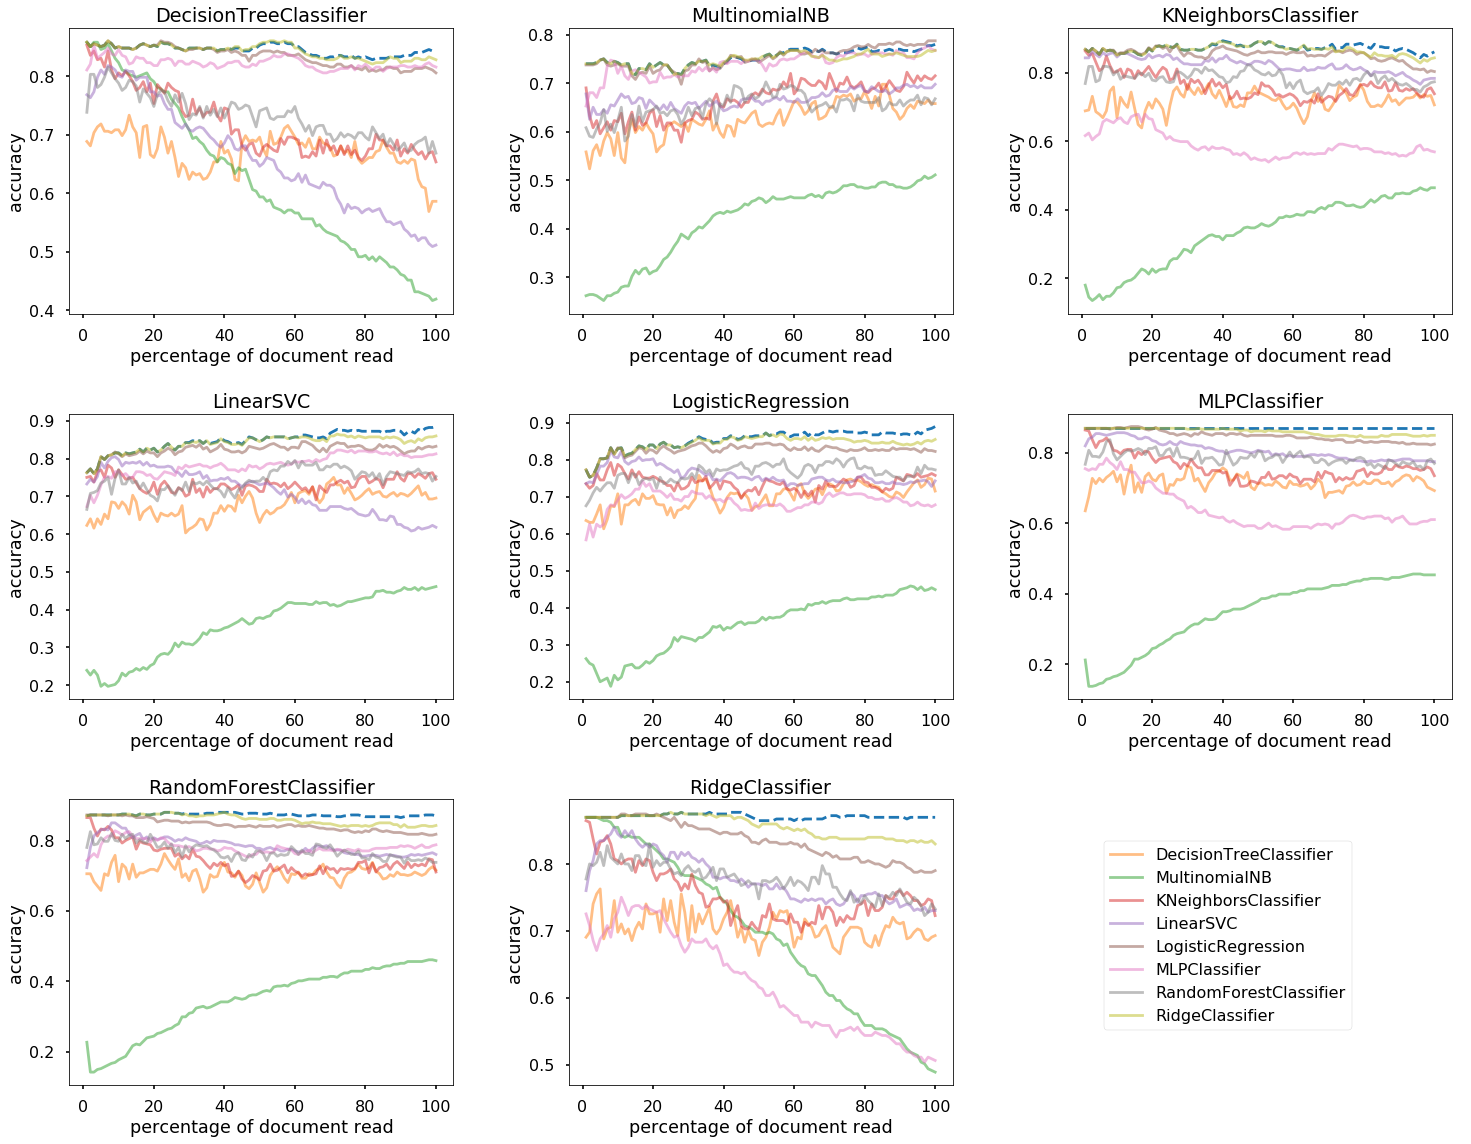

In [5]:
penalization_type = 'Losada-Crestani'
time_threshold_1 = 5
time_threshold_2 = 50
costs_1 = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 1.0}
costs_2 = {'c_tp': 1.0,
         'c_fn': 1.0,
         'c_fp': 'proportion_positive_cases'}
costs_3 = {'c_tp': 1.0,
         'c_fn': 10.0,
         'c_fp': 1.0}

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
ax = np.ravel(ax)
table = []
table_columns = ['CPI Model', 'DMC Model', 'Precision', 'Recall', 'F1 Score', 'Accuracy',
                 f'EDE o={time_threshold_1}', f'EDE o={time_threshold_1} Proportional',
                 f'EDE o={time_threshold_1} FN', f'EDE o={time_threshold_2}',
                 f'EDE o={time_threshold_2} Proportional', f'EDE o={time_threshold_2} FN']
plot_data = []
already_preprocess = False
for cpi_num, cpi_name in enumerate(cpi_clf_names):
    cpi_clf = get_cpi_classifier(cpi_name)
    cpi_kwargs['cpi_clf'] = cpi_clf
    y_dmc_list = []
    for dmc_num, dmc_name in enumerate(dmc_clf_names):
        print(f'Working with models CPI: {cpi_name}, DMC: {dmc_name}')
        dmc_clf = get_dmc_classifier(dmc_name)
        dmc_kwargs['dmc_clf'] = dmc_clf
        if not already_preprocess:
            etc = EarlyTextClassifier(etc_kwargs, preprocess_kwargs, cpi_kwargs,
                          context_kwargs, dmc_kwargs, verbose=False)
            Xtrain, ytrain, Xtest, ytest = etc.preprocess_dataset()
            already_preprocess = True
        else:
            etc = EarlyTextClassifier(etc_kwargs, preprocess_kwargs, cpi_kwargs,
                          context_kwargs, dmc_kwargs, etc.unique_labels, etc.dictionary, verbose=False)
        etc.fit(Xtrain, ytrain)
        cpi_perc, cpi_pred, dmc_pred, pred_time, dmc_ytest = etc.predict(Xtest, ytest)
        etc.save_model()
        precision_etc, recall_etc, f1_etc, accuracy_etc, ede_score_1_o5 = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, time_threshold_1, costs_1, print_ouput=False)
        _, _, _, _, ede_score_2_o5 = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, time_threshold_1, costs_2, print_ouput=False)
        _, _, _, _, ede_score_3_o5 = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, time_threshold_1, costs_3, print_ouput=False)
        _, _, _, _, ede_score_1_o50 = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, time_threshold_2, costs_1, print_ouput=False)
        _, _, _, _, ede_score_2_o50 = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, time_threshold_2, costs_2, print_ouput=False)
        _, _, _, _, ede_score_3_o50 = etc.score(ytest, cpi_pred, cpi_perc, pred_time, penalization_type, time_threshold_2, costs_3, print_ouput=False)
        fila = [cpi_name, dmc_name, precision_etc, recall_etc, f1_etc, accuracy_etc, ede_score_1_o5,
                ede_score_2_o5, ede_score_3_o5, ede_score_1_o50, ede_score_2_o50, ede_score_3_o50]
        table.append(fila)
        
        # Plot
        num_steps = len(cpi_perc)
        x = cpi_perc
        y_cpi = np.zeros(num_steps)
        y_dmc = np.zeros(num_steps)
        for idx in range(num_steps):
            y_cpi[idx] = np.sum(cpi_pred[idx] == ytest) / ytest.size
            y_dmc[idx] = np.sum(dmc_pred[idx] == dmc_ytest[idx]) / dmc_ytest[idx].size

        if dmc_num == 0:
            ax[cpi_num].plot(x, y_cpi, linestyle='--')
        ax[cpi_num].plot(x, y_dmc, label=dmc_name, alpha=0.5)
        y_dmc_list.append(y_dmc)
    ax[cpi_num].set_xlabel('percentage of document read')
    ax[cpi_num].set_ylabel('accuracy')
    ax[cpi_num].set_title(cpi_name)
    plot_data.append((y_cpi, y_dmc_list))
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.75, 0.1))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.98, wspace=.3,
                    hspace=.35)
ax[-1].set_axis_off();

In [6]:
df = pd.DataFrame(table, columns=table_columns)
df.sort_values('EDE o=50 Proportional', ascending=True)

,CPI Model,DMC Model,Precision,Recall,F1 Score,Accuracy,EDE o=5,EDE o=5 Proportional,EDE o=5 FN,EDE o=50,EDE o=50 Proportional,EDE o=50 FN
8,MultinomialNB,DecisionTreeClassifier,0.608255,0.693079,0.616752,0.750623,0.260923,0.087292,0.709801,0.249377,0.075746,0.698254
10,MultinomialNB,KNeighborsClassifier,0.601346,0.676714,0.609618,0.750623,0.255926,0.086636,0.749691,0.249377,0.080087,0.743142
14,MultinomialNB,RandomForestClassifier,0.600703,0.671396,0.610046,0.755611,0.252285,0.089506,0.768494,0.244389,0.081610,0.760599
15,MultinomialNB,RidgeClassifier,0.588674,0.654618,0.594003,0.740648,0.260608,0.086977,0.799261,0.259352,0.085721,0.798005
12,MultinomialNB,LogisticRegression,0.588674,0.654618,0.594003,0.740648,0.263056,0.089426,0.801710,0.261845,0.088215,0.800499
13,MultinomialNB,MLPClassifier,0.584986,0.646435,0.590141,0.740648,0.278151,0.106691,0.839249,0.263713,0.092253,0.824811
32,LogisticRegression,DecisionTreeClassifier,0.567481,0.582213,0.572728,0.785536,0.216053,0.107534,1.024033,0.214464,0.105945,1.022444
11,MultinomialNB,LinearSVC,0.607194,0.682444,0.618004,0.760599,0.271956,0.111347,0.765721,0.266715,0.106106,0.760480
38,LogisticRegression,RandomForestClassifier,0.535061,0.538434,0.536416,0.780549,0.220271,0.118263,1.140470,0.219451,0.117443,1.139651
36,LogisticRegression,LogisticRegression,0.529870,0.534136,0.531307,0.773067,0.227426,0.118907,1.147626,0.226933,0.118413,1.147132
